In [105]:
import netCDF4 as nc
import pylab as plt
import numpy as np
import pandas as pd
from mpl_toolkits.basemap import Basemap, shiftgrid
import numpy.ma as MA
import cf
import cfplot as cfp

In [106]:
data = nc.Dataset('/homes/njw44/data/ukca/cl_field_interpolation/best_cl_estimate.nc')
cl = data.variables['CL_mm'][:,10:,:,:]
#print(cl)

In [107]:
#print(cl_data)

In [110]:
press = data.variables['p_mm'][:,10:,:,:]
alt = data.variables['niv'][10:]
temp = data.variables['te_mm'][:,10:,:,:]

lat = data.variables['lat'][:]
lon = data.variables['lon'][:]
#alt_cl = cl_data.variables['level_height'][:]

In [111]:
#Convert Cl ppbv into no. molecules per cm3
r_gas = 8.3145
n_a = 6.02e23
conv_1 = (n_a)/(1e9*r_gas*1e6)*(np.divide(press,temp))
cl_conc = np.multiply(cl,conv_1)

/home/znjs2/.conda/envs/basemap/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


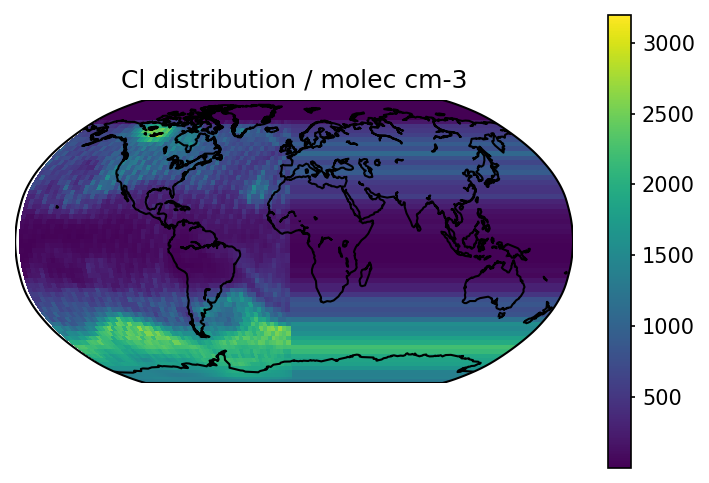

In [112]:
plt.figure(dpi=150)
map = Basemap(projection='robin', lon_0=0.)
map.drawcoastlines()

lonx,laty = np.meshgrid(lon,lat)
x,y=map(lonx,laty)

cs = map.pcolormesh(x,y,cl_conc[0,0,:,:])

plt.title('Cl distribution / molec cm-3')
plt.colorbar()
plt.show()

In [113]:
zon_press = np.mean(press, axis=(0,3))
zon_cl = np.mean(cl_conc, axis=(0,3))
print(zon_press.shape)

(21, 64)


In [114]:
#get zones by pressure
height_1 = MA.masked_less(zon_press, 75000)
height_2 = MA.masked_outside(zon_press, 75000, 50000)
height_3 = MA.masked_outside(zon_press, 50000,25000)

In [144]:
lat_array = np.array([lat] * 21)

sec_1 = MA.masked_greater(lat_array,-30)
sec_2 = MA.masked_outside(lat_array, -30, 0)
sec_3 = MA.masked_outside(lat_array, 0, 30)
sec_4 = MA.masked_less(lat_array, 30)


In [124]:
heights = [height_1.mask, height_2.mask, height_3.mask]
sections = [sec_1.mask, sec_2.mask, sec_3.mask, sec_4.mask]
conditions = []
for h in heights:
    for s in sections:
        conditions.append([h,s])
cond = np.asarray(conditions)
#print(cond.shape)
#print(cond[0,:,:,:])

In [164]:
#loop over conditions to get mean for each area
law_cl = np.empty((21,64))
mean_vals = []
for i in range(12):
    values = MA.masked_where(np.logical_or(*cond[i,:,:,:]),zon_cl) #extract temp values in section
    mean = np.mean(values) #get mean over this section
    mean_vals.append(mean)
    law_cl = np.where(values.mask, law_cl, mean)

law_cl2 = MA.masked_where(zon_press < 25000, law_cl)
law_cl3 = MA.masked_where(zon_press < 50000, law_cl)
#print(alt)

In [126]:
#Make boundary for Lawrence plot
bound_750 = []
for i in range(64):
    for j in range(21):
        if zon_press[j,i] > 75000:
            bound_750.append(j+1)
            break
            
bound_500 = []          
for i in range(64):
    for j in range(21):
        if zon_press[j,i] > 50000:
            bound_500.append(j+1)
            break


Text(0.5, 1.0, 'Mean [Cl] by region (Hossaini) / molec cm-3')

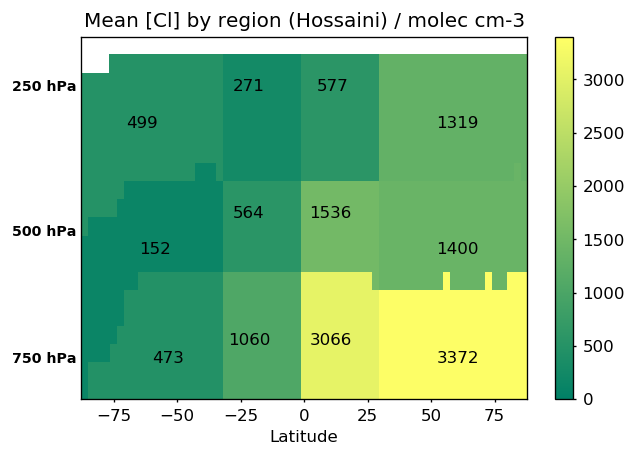

In [167]:
plt.figure(dpi=120)
plt.pcolormesh(lat,list(reversed(range(21))),law_cl2, cmap='summer',vmin=0, vmax=3400)
plt.colorbar()

#plt.gca().invert_yaxis()

#plt.plot(lat,bound_750, 'k-', lw=1, ls='dotted')
#plt.plot(lat,bound_500, 'k-', lw=1, ls='dotted')

plt.yticks([])

plt.text(-60,2,f'{mean_vals[0]:.0f}')
plt.text(-30,3,f'{mean_vals[1]:.0f}')
plt.text(2,3,f'{mean_vals[2]:.0f}')
plt.text(52,2,f'{mean_vals[3]:.0f}')
plt.text(-65,8,f'{mean_vals[4]:.0f}')
plt.text(-28,10,f'{mean_vals[5]:.0f}')
plt.text(2,10,f'{mean_vals[6]:.0f}')
plt.text(52,8,f'{mean_vals[7]:.0f}')
plt.text(-70,15,f'{mean_vals[8]:.0f}')
plt.text(-28,17,f'{mean_vals[9]:.0f}')
plt.text(5,17,f'{mean_vals[10]:.0f}')
plt.text(52,15,f'{mean_vals[11]:.0f}')

#label pressures
plt.text(-115,2,'750 hPa',fontsize=8.5, weight='bold')
plt.text(-115,9,'500 hPa',fontsize=8.5, weight='bold')
plt.text(-115,17,'250 hPa',fontsize=8.5, weight='bold')

#plt.axvline(x=0, linewidth=1, linestyle=(0,(1,2)), color='k')
#plt.axvline(x=30, linewidth=1, linestyle=(0,(1,2)), color='k')
#plt.axvline(x=-30, linewidth=1, linestyle=(0,(1,2)), color='k')

plt.xlabel('Latitude')
#plt.ylabel('Model level')
plt.title('Mean [Cl] by region (Hossaini) / molec cm-3')

In [121]:
cfp.con(f=law_cl2, x=lat, y=alt, ptype=2,lines=False)

Warning: 
Input arguments incorrectly shaped:
x has shape:(64,)
y has shape:(21,)
field has shape(31, 64)

Expected x=xpts, y=ypts, field=(ypts,xpts)
x=npts, y=npts, field=npts
or x=[ypts, xpts], y=[ypts, xpts], field=[ypts, xpts]
